First we have to download and install the pip package

In [127]:
import numpy as np
import torch.nn as nn
from ncps.wirings import AutoNCP 
from ncps.torch import LTC
import pytorch_lightning as pl
import torch
import torch.utils.data as data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



In [ ]:
!nvidia-smi

Tue May 16 16:48:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100S-PCI...  On   | 00000000:81:00.0 Off |                    0 |
| N/A   32C    P0    36W / 250W |    310MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [264]:
df0 = pd.read_csv("/d/hpc/home/ld8435/liquid_time_constant_networks/experiments_with_ltcs/data/bicikelj/bicikelj_one.csv")
df0

,date,value,temp_c,is_day,wind_kph,cloud,precip_mm,humidity,will_it_rain,bikes_plus_120mins,bikes_plus_60mins
0,2022-08-02 13:10:00,18,29.8,1.0,2.9,7.0,0.0,36.0,0.0,16,19
1,2022-08-02 13:14:00,17,29.8,1.0,2.9,7.0,0.0,36.0,0.0,19,16
2,2022-08-02 13:20:00,18,29.8,1.0,2.9,7.0,0.0,36.0,0.0,19,14
3,2022-08-02 13:25:00,20,29.8,1.0,2.9,7.0,0.0,36.0,0.0,18,16
4,2022-08-02 13:30:00,19,29.8,1.0,2.9,7.0,0.0,36.0,0.0,20,16
...,...,...,...,...,...,...,...,...,...,...,...
7733,2022-10-01 18:03:00,18,13.9,1.0,14.4,34.0,0.0,84.0,0.0,20,20
7734,2022-10-01 18:07:00,20,13.9,1.0,14.4,34.0,0.0,84.0,0.0,20,20
7735,2022-10-01 18:13:00,19,13.9,1.0,14.4,34.0,0.0,84.0,0.0,20,20
7736,2022-10-01 18:16:00,19,13.9,1.0,14.4,34.0,0.0,84.0,0.0,20,20


In [265]:
import datetime as dt
def load_bikes(predict_hour=1):
    df = pd.read_csv("/d/hpc/home/ld8435/liquid_time_constant_networks/experiments_with_ltcs/data/bicikelj/bicikelj_one.csv")

    #resample to 10 minutes
    df["date"] = pd.to_datetime(df["date"])
    df = df.set_index("date")
    df = df.resample("1h").mean()
    df = df.reset_index()

    

    #back to string
    df["date"] = df["date"].astype(str)

    #set missing values to 0

    #remove missing values
    df = df.dropna()

    #fill temp with averagte temp
    df["temp_c"] = df["temp_c"].fillna(df["temp_c"].mean())
    #bckfill rain
    #df["will_it_rain"] = df["will_it_rain"].fillna(method="backfill")
    #backfill cloud
    #df["cloud"] = df["cloud"].fillna(method="backfill")
    df["will_it_rain"] = df["will_it_rain"].fillna(method="backfill")
    

    #set missing values to 0
    df["value"] = df["value"].fillna(0)
    df["is_day"] = df["date"].apply(lambda x: 1 if " 06:" in x and " 22:" not in x else 0)
    df["precip_mm"] = df["precip_mm"].fillna(method="backfill")
    df["humidity"] = df["humidity"].fillna(df["humidity"].mean())

    
   

    



    #holiday = (df["holiday"].values == None).astype(np.float32)
    temp = df["temp_c"].values.astype(np.float32)
    temp -= np.mean(temp)  # normalize temp by annual mean
    humidity = df["humidity"].values.astype(np.float32)
    humidity -= np.mean(humidity)  # normalize humidity by annual mean

    #rain = df["will_it_rain"].values.astype(np.float32)
    #snow = df["snow_1h"].values.astype(np.float32)
    #clouds = df["cloud"].values.astype(np.float32)
    precip_mm = df["precip_mm"].values.astype(np.float32)
    date_time = df["date"].values
    # 2012-10-02 13:00:00
    date_time = [dt.datetime.strptime(d, "%Y-%m-%d %H:%M:%S") for d in date_time]
    

    hour_of_day = np.array([d.hour for d in date_time]).astype(np.float32)
    day_of_week = np.array([d.weekday() for d in date_time]).astype(np.float32)

    bikes_plus_120mins = df["bikes_plus_120mins"].values.astype(np.float32)
    #bikes_plus_60mins = df["bikes_plus_60mins"].values.astype(np.float32)

    df["bikes_plus_60mins"] = df['value'].shift(-1)
    bikes_plus_60mins = df["bikes_plus_60mins"].values.astype(np.float32)
    bikes_plus_60mins[-1] = bikes_plus_60mins[-2]

    df["bikes_plus_120mins"] = df['value'].shift(-2)
    bikes_plus_120mins = df["bikes_plus_120mins"].values.astype(np.float32)
    bikes_plus_120mins[-1] = bikes_plus_120mins[-2]
    bikes_plus_120mins[-2] = bikes_plus_120mins[-3]

    #print(df.isnull().sum())

    traffic_volume = df["value"].values.astype(np.float32)

    prev_hour_bikes = np.zeros_like(traffic_volume)
    prev_hour_bikes[1:] = traffic_volume[:-1]
    prev_hour_bikes[0] = traffic_volume[0]

    features = np.stack([temp,precip_mm,humidity, hour_of_day,day_of_week,prev_hour_bikes], axis=-1)

    # traffic_volume -= np.mean(traffic_volume)  # normalize
    # traffic_volume /= np.std(traffic_volume)  # normalize

    #return date_time,features, traffic_volume
    # if predict_hour == 1:
    #     return date_time,features, bikes_plus_60mins

    # elif predict_hour == 2:
    #     return date_time,features, bikes_plus_120mins

    df["traffic_in_1h"] = df['value'].shift(-1)
    y2 = df["traffic_in_1h"].values.astype(np.float32)
    y2[-1] = y2[-2]  # Fill last value with second to last value

    return date_time,features,traffic_volume,y2


def cut_in_sequences(x, y, seq_len, inc=1):

    sequences_x = []
    sequences_y = []

    for s in range(0, x.shape[0] - seq_len, inc):
        start = s
        end = start + seq_len
        sequences_x.append(x[start:end])
        sequences_y.append(y[start:end])

    return np.stack(sequences_x, axis=1), np.stack(sequences_y, axis=1)





target             1.000000
prev_hour_bikes    0.821037
temp               0.544259
hour_of_day        0.390980
day_of_week        0.024758
precip_mm         -0.119867
humidity          -0.588918
Name: target, dtype: float64
target             1.000000
prev_hour_bikes    0.593163
temp               0.515084
hour_of_day        0.265972
day_of_week        0.014754
precip_mm         -0.119872
humidity          -0.553968
Name: target, dtype: float64


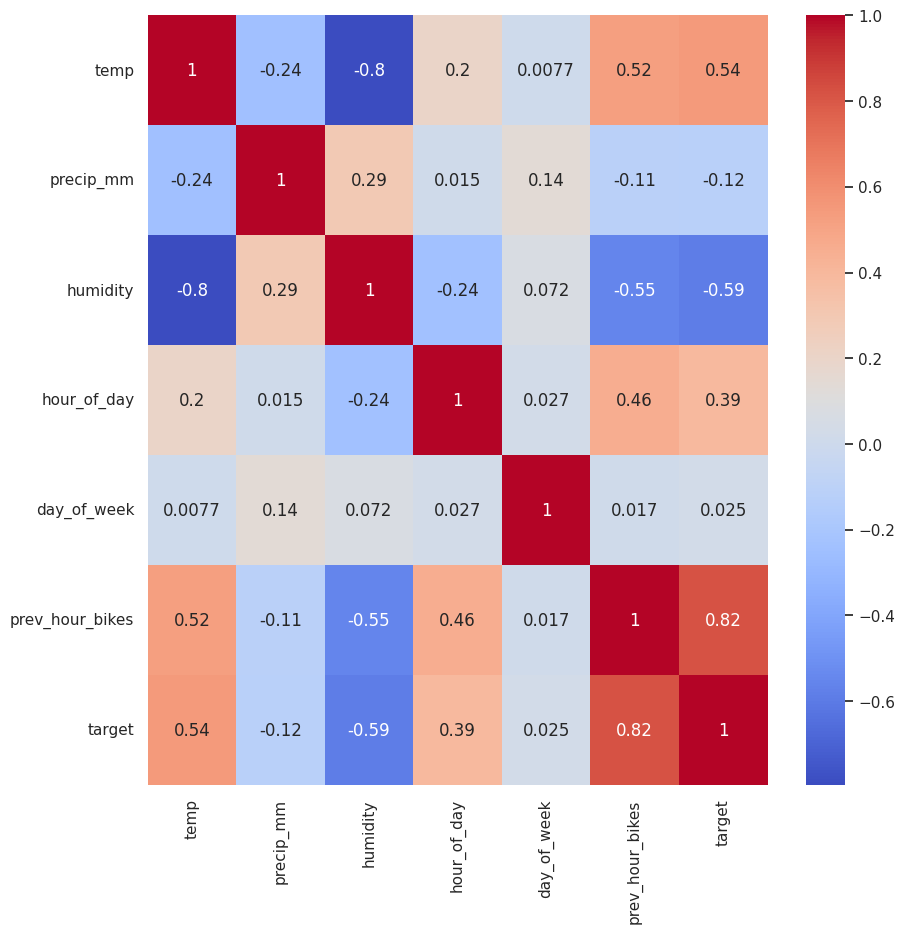

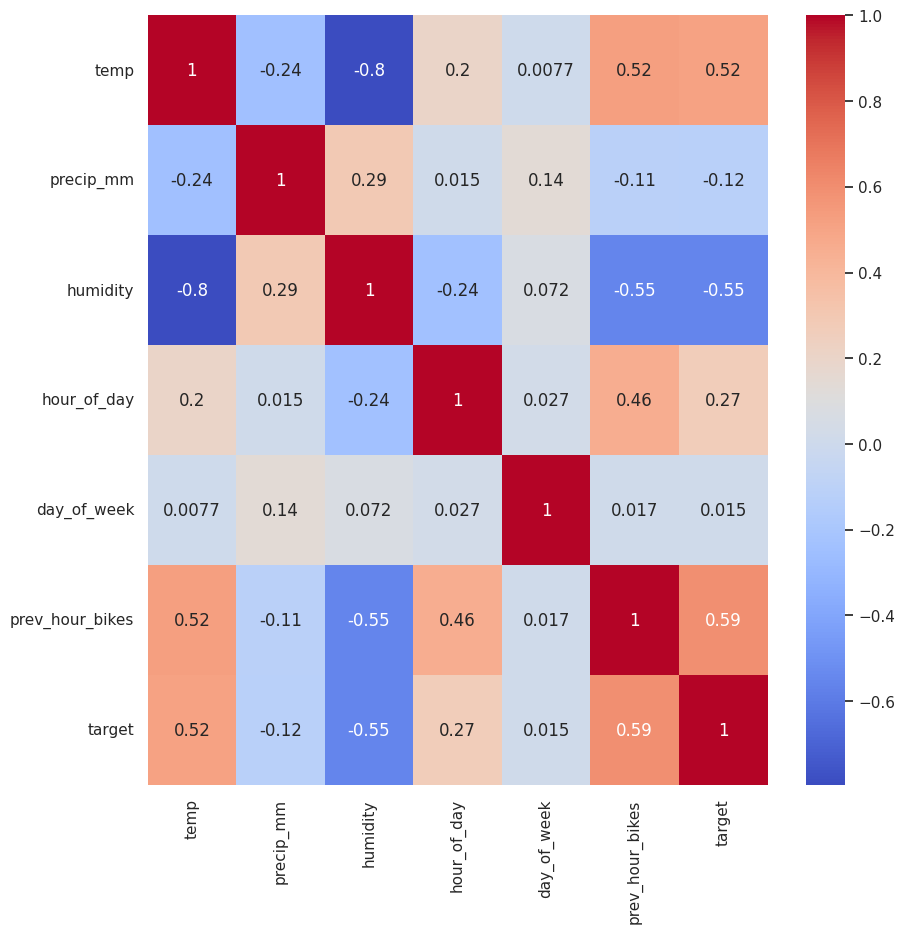

In [266]:
date_time, x, y,y2 = load_bikes(predict_hour=1)

#plot using plotyly
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=date_time, y=y,
                    mode='lines',
                    name='target'))
#names     features = np.stack([temp, rain,precip_mm, clouds, weekday, hour_of_day,day_of_week,traffic_volume], axis=-1)
#temp,precip_mm,humidity, hour_of_day,day_of_week,traffic_volume
names = ["temp","precip_mm","humidity","hour_of_day","day_of_week","prev_hour_bikes"]
for i in range(0,x.shape[1]):
    fig.add_trace(go.Scatter(x=date_time, y=x[:,i],
                    mode='lines',
                    name=names[i]))
    


fig.show()


#plot coorelation beetwen target and features using plotly
df = pd.DataFrame(x, columns=names)
df["target"] = y
corr = df.corr()

plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, cmap="coolwarm")

print(corr["target"].sort_values(ascending=False))

df2 = pd.DataFrame(x, columns=names)
df2["target"] = y2
corr = df2.corr()

plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, cmap="coolwarm")

print(corr["target"].sort_values(ascending=False))







In [267]:
from torch.utils.data import Dataset, DataLoader
import datetime as dt

class TrafficDataset(Dataset):
    def __init__(self, seq_len=8, exclude_timestamps=None,freqency='1h', predict_hour=1,inc=1):
        date_time, x, y,y2 = load_bikes(predict_hour=predict_hour)
        date_time = np.array(date_time)

        x = np.array(x)
        y = np.array(y)
        y2 = np.array(y2)


        print("x.shape", x.shape)
        print("y.shape", y.shape)
        print("y2.shape", y2.shape)

        if exclude_timestamps is not None:
            exclude_timestamps = [dt.datetime.strptime(ts, "%Y-%m-%d %H:%M:%S") for ts in exclude_timestamps]
            #round to nearest hour
            exclude_timestamps = [ts.replace(minute=0, second=0) for ts in exclude_timestamps]
            print("Excluding {} timestamps".format(len(exclude_timestamps)))

            #prind exclude_timestamps
            indices_to_keep = [i for i, dt in enumerate(date_time) if dt not in exclude_timestamps]
            print("Keeping {} timestamps".format(len(indices_to_keep)))

            print("before", x.shape)
            
            date_time = date_time[indices_to_keep]
            x = x[indices_to_keep]
            print("after", x.shape)
            y = y[indices_to_keep]
            y2 = y2[indices_to_keep]

        self.x, self.y = cut_in_sequences(x, y, seq_len, inc=inc)
        self.x, self.y2 = cut_in_sequences(x, y2, seq_len, inc=inc)
        print("dataset x.shape", self.x.shape)
        print("date_time.shape", date_time.shape)

    def __len__(self):
        return self.x.shape[1]

    def __getitem__(self, idx):
        
        #return self.x[:, idx], self.y[:, idx].reshape(-1, 1)
        #return self.x[:, idx], self.y[:, idx].reshape(-1, 1), self.y2[:, idx].reshape(-1, 1)
        y_combined = np.stack([self.y[:, idx].reshape(-1, 1), self.y2[:, idx].reshape(-1, 1)], axis=-1)
        return self.x[:, idx], y_combined




For the training we will use Pytorch-Lightning, thus we have to define our learner module. 

In [268]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_lightning.callbacks import LearningRateMonitor, EarlyStopping

class SequenceLearner(pl.LightningModule):
    def __init__(self, model, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        
        # calculate MAE for each target separately
        mae1 = nn.L1Loss()(y_hat[..., 0], y[..., 0])
        mae2 = nn.L1Loss()(y_hat[..., 1], y[..., 1])
        self.log("tm1", mae1, prog_bar=True)
        self.log("tm2", mae2, prog_bar=True)

        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)
        self.log("val_loss", loss, prog_bar=True)
        
        # calculate MAE for each target separately
        mae1 = nn.L1Loss()(y_hat[..., 0], y[..., 0])
        mae2 = nn.L1Loss()(y_hat[..., 1], y[..., 1])
        self.log("vm1", mae1, prog_bar=True)
        self.log("vm2", mae2, prog_bar=True)

        return loss

    def test_step(self, batch, batch_idx):
        return self.validation_step(batch, batch_idx)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

    


Next we define some toy dataset and create the corresponding DataLoaders

x.shape (710, 6)
y.shape (710,)
y2.shape (710,)
Excluding 40 timestamps
Keeping 710 timestamps
before (710, 6)
after (710, 6)
dataset x.shape (8, 351, 6)
date_time.shape (710,)


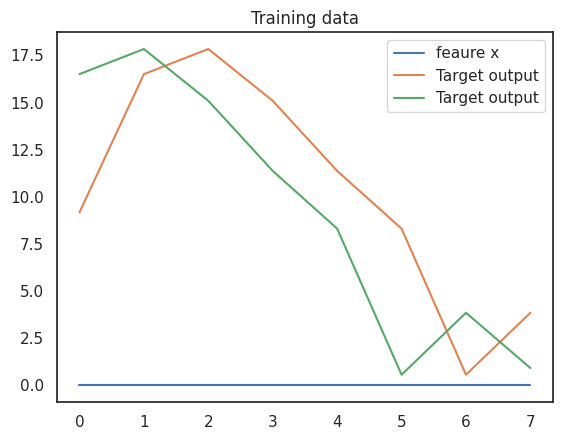

/d/hpc/home/ld8435/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning:

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /d/hpc/home/ld8435/miniconda3/envs/pytorch_env/lib/p ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


alloc!


In [274]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader
timestamps = [
    "2022-08-04 23:24:00",
    "2022-08-05 00:24:00",
    "2022-08-08 04:58:00",
    "2022-08-08 05:58:00",
    "2022-08-11 21:13:00",
    "2022-08-11 22:13:00",
    "2022-08-16 07:10:00",
    "2022-08-16 08:10:00",
    "2022-08-18 17:30:00",
    "2022-08-18 18:27:00",
    "2022-08-21 11:07:00",
    "2022-08-21 12:07:00",
    "2022-08-24 15:09:00",
    "2022-08-24 16:09:00",
    "2022-08-29 03:05:00",
    "2022-08-29 04:01:00",
    "2022-08-31 06:37:00",
    "2022-08-31 07:34:00",
    "2022-09-03 15:48:00",
    "2022-09-03 16:42:00",
    "2022-09-05 18:34:00",
    "2022-09-05 19:35:00",
    "2022-09-08 07:44:00",
    "2022-09-08 08:44:00",
    "2022-09-10 05:50:00",
    "2022-09-10 06:50:00",
    "2022-09-12 09:32:00",
    "2022-09-12 10:32:00",
    "2022-09-17 18:25:00",
    "2022-09-17 19:25:00",
    "2022-09-20 23:43:00",
    "2022-09-21 00:40:00",
    "2022-09-23 13:36:00",
    "2022-09-23 14:36:00",
    "2022-09-26 07:09:00",
    "2022-09-26 08:10:00",
    "2022-09-29 03:14:00",
    "2022-09-29 04:10:00",
    "2022-10-01 19:27:00",
    "2022-10-01 20:27:00",
    ]

# Instantiate the TrafficDataset
dataset = TrafficDataset(seq_len=8, exclude_timestamps=timestamps,freqency="1h",predict_hour=1,inc=2)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)

# Get a batch of data
data_x, data_y = next(iter(dataloader))

# Calculate the sizes of the train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset into train, validation, and test sets
train_data, val_data, test_data = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for train, validation, and test sets
train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_data, batch_size=16, shuffle=False, num_workers=0)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=False, num_workers=0)


# Example usage of the train, validation, and test DataLoaders
# train_batch_x, train_batch_y = next(iter(train_dataloader))
# val_batch_x, val_batch_y = next(iter(val_dataloader))
# test_batch_x, test_batch_y = next(iter(test_dataloader))

# Convert to torch.Tensor
data_x = torch.Tensor(data_x)
data_y = torch.Tensor(data_y)

# Let's visualize the training data
# sns.set()
# plt.figure(figsize=(6, 4))

# The visualization might change depending on the structure of your data
# Here, I'm assuming your data has two features and one target variable.
# Modify accordingly if your data structure is different.
plt.plot(data_x[0, :, 4], label="feaure x")
plt.plot(data_y[0, :,0], label="Target output")

plt.title("Training data")
plt.legend(loc="upper right")
plt.show()

# #plotly plot

from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_lightning.callbacks import LearningRateMonitor, EarlyStopping

wiring = AutoNCP(64, 2)  # 16 units, 1 motor neuron

ltc_model = LTC(6, wiring, batch_first=True)
learn = SequenceLearner(ltc_model, lr=0.01)

# Define early stopping criteria
early_stop_callback = EarlyStopping(
   monitor='val_loss',
   min_delta=0.00,  # minimum value of the change in val_loss for the change to be considered an improvement
   patience=20,  # number of epochs with no improvement after which training will be stopped
   verbose=False,
)

lr_monitor = LearningRateMonitor(logging_interval='step')

trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=600,
    gradient_clip_val=1,  # Clip gradient to stabilize training
    devices=1,  # Use GPU
    accelerator='gpu',
    log_every_n_steps=1,
    callbacks=[early_stop_callback, lr_monitor]
)





In [201]:
data_y.shape

torch.Size([1, 8, 1, 2])

Here we can finally create a LTCCell and make use of the predefined sparse wiring structures of the keras-ncp package. For simplicity we will just define a fully-connected RNN

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


alloc!


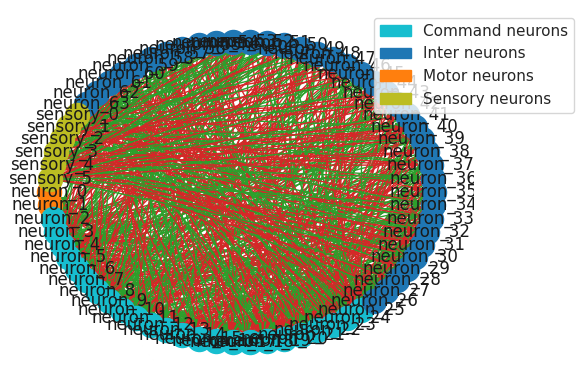

In [271]:
sns.set_style("white")
plt.figure(figsize=(6, 4))
legend_handles = wiring.draw_graph(draw_labels=True,  neuron_colors={"command": "tab:cyan"})
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1, 1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

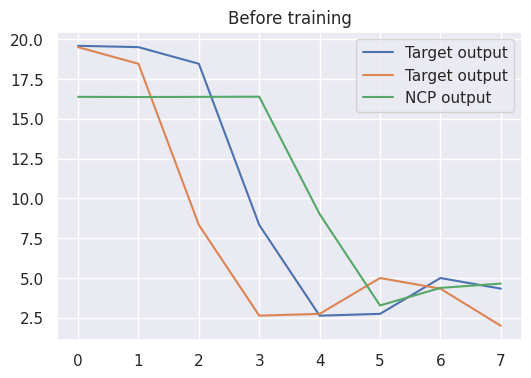

In [202]:
sns.set()
with torch.no_grad():
  prediction = ltc_model(data_x)[0].numpy()
plt.figure(figsize=(6, 4))
plt.plot(data_y[0, :, 0], label="Target output")
plt.plot(prediction[0, :, 0], label="NCP output")

plt.title("Before training")
plt.legend(loc="upper right")
plt.show()

... and train our network 

In [275]:
trainer.fit(learn, train_dataloader, val_dataloader)


/d/hpc/home/ld8435/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning:

Checkpoint directory log/lightning_logs/version_0/checkpoints exists and is not empty.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | LTC  | 22.6 K
-------------------------------
18.1 K    Trainable params
4.5 K     Non-trainable params
22.6 K    Total params
0.090     Total estimated model params size (MB)
/d/hpc/home/ld8435/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/lightning_fabric/loggers/csv_logs.py:188: UserWarning:

Experiment logs directory log/lightning_logs/version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!



/d/hpc/home/ld8435/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/d/hpc/home/ld8435/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Epoch 121: 100%|██████████| 123/123 [00:28<00:00,  4.36it/s, v_num=0, train_loss=7.560, tm1=1.720, tm2=2.060, val_loss=9.740, vm1=1.750, vm2=2.230]


In [276]:
results = trainer.test(learn, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/d/hpc/home/ld8435/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 38.25it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │     9.959558486938477     │
│            vm1            │    1.6206640005111694     │
│            vm2            │    2.2588584423065186     │
└───────────────────────────┴───────────────────────────┘

(1, 8, 2)


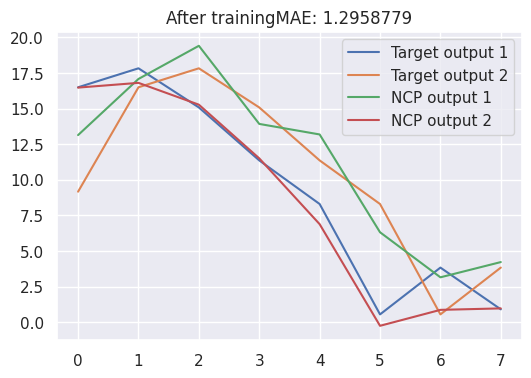

In [277]:
sns.set()
with torch.no_grad():
  prediction = ltc_model(data_x)[0].numpy()
  print(prediction.shape)
plt.figure(figsize=(6, 4))
plt.plot(data_y[0, :, 0,1], label="Target output 1")
plt.plot(data_y[0, :, 0,0], label="Target output 2")
plt.plot(prediction[0, :, 0], label="NCP output 1")
plt.plot(prediction[0, :, 1], label="NCP output 2")

from sklearn.metrics import mean_absolute_error

# Assuming prediction and data_y are already defined and are in the same shape
mae = mean_absolute_error(data_y.flatten(), prediction.flatten())


plt.title("After training" + "MAE: " + str(mae))
plt.legend(loc="upper right")
plt.show()

In [324]:
data_x.shape

torch.Size([1, 6, 6])

In [278]:
#test whole dataset
full = TrafficDataset(seq_len=6, exclude_timestamps=timestamps,freqency="1h",predict_hour=1,inc=2)

# Create a DataLoader
dataloader2 = DataLoader(full, batch_size=1, num_workers=0)

predictions = [] 
ys = []   
with torch.no_grad():
    for x, y in dataloader2:
        predictions.append(ltc_model(x)[0].numpy())
        ys.append(y.numpy())

predictions = np.concatenate(predictions, axis=0)

# Plot the predictions suing plotly
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(y=predictions.flatten(),
                    mode='lines',
                    name='predictions'))
fig.add_trace(go.Scatter(y=np.concatenate(ys, axis=0).flatten(),
                    mode='lines',
                    name='target'))


fig.update_layout(
    xaxis_title='Time step',
    yaxis_title='Prediction',
    title='Predictions over time'
)

fig.show()



x.shape (710, 6)
y.shape (710,)
y2.shape (710,)
Excluding 40 timestamps
Keeping 710 timestamps
before (710, 6)
after (710, 6)
dataset x.shape (6, 352, 6)
date_time.shape (710,)


In [279]:
#test whole dataset
full = TrafficDataset(seq_len=6, exclude_timestamps=timestamps, freqency="1h", predict_hour=1, inc=2)

# Create a DataLoader
dataloader2 = DataLoader(full, batch_size=1, num_workers=0)

predictions = [] 
ys = []   
with torch.no_grad():
    for x, y in dataloader2:
        # Append only the last prediction of each sequence
        predictions.append(ltc_model(x)[0].numpy()[:, -1, :])
        # print(y.shape)
        # print(ltc_model(x)[0].numpy().shape)

        ys.append(y.numpy()[:, -1, :])

predictions = np.concatenate(predictions, axis=0)
ys = np.concatenate(ys, axis=0)

# Plot the predictions using plotly
import plotly.graph_objects as go

from sklearn.metrics import mean_absolute_error
#remove 3 rd dimension in ys but keep 4th
print(ys.shape)
print(predictions.shape)
ys = ys.reshape(ys.shape[0], -1)  # reshape to (352, 2)

# Compute the MAE for both output variables
mae_1 = mean_absolute_error(ys[:, 0], predictions[:, 0])
mae_2 = mean_absolute_error(ys[:, 1], predictions[:, 1])
print("Mean Absolute Error for output 1:", mae_1)
print("Mean Absolute Error for output 2:", mae_2)

#import make_subplots
from plotly.subplots import make_subplots


fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Scatter(y=predictions[:, 0],
                    mode='lines',
                    name='predictions for output 1'), row=1, col=1)
fig.add_trace(go.Scatter(y=ys[:, 0],
                    mode='lines',
                    name='target for output 1'), row=1, col=1)

fig.add_trace(go.Scatter(y=predictions[:, 1],
                    mode='lines',
                    name='predictions for output 2'), row=2, col=1)
fig.add_trace(go.Scatter(y=ys[:, 1],
                    mode='lines',
                    name='target for output 2'), row=2, col=1)

fig.update_layout(
    title='Last predictions over time',
    height=800
)

fig.update_yaxes(title_text="Prediction for output 1 (MAE: " + str(mae_1) + ")", row=1, col=1)
fig.update_yaxes(title_text="Prediction for output 2 (MAE: " + str(mae_2) + ")", row=2, col=1)

fig.update_xaxes(title_text="Time step", row=2, col=1)

fig.show()



x.shape (710, 6)
y.shape (710,)
y2.shape (710,)
Excluding 40 timestamps
Keeping 710 timestamps
before (710, 6)
after (710, 6)
dataset x.shape (6, 352, 6)
date_time.shape (710,)
(352, 1, 2)
(352, 2)
Mean Absolute Error for output 1: 1.4028095
Mean Absolute Error for output 2: 1.6994885


In [280]:
#test test dataset

predictions = [] 
ys = []   
with torch.no_grad():
    for x, y in test_dataloader:
        # Append only the last prediction of each sequence
        predictions.append(ltc_model(x)[0].numpy()[:, -1, :])
        # print(y.shape)
        # print(ltc_model(x)[0].numpy().shape)

        ys.append(y.numpy()[:, -1, :])

predictions = np.concatenate(predictions, axis=0)
ys = np.concatenate(ys, axis=0)

# Plot the predictions using plotly
import plotly.graph_objects as go

from sklearn.metrics import mean_absolute_error
#remove 3 rd dimension in ys but keep 4th
print(ys.shape)
print(predictions.shape)
ys = ys.reshape(ys.shape[0], -1)  # reshape to (352, 2)

# Compute the MAE for both output variables
mae_1 = mean_absolute_error(ys[:, 0], predictions[:, 0])
mae_2 = mean_absolute_error(ys[:, 1], predictions[:, 1])
print("Mean Absolute Error for output 1:", mae_1)
print("Mean Absolute Error for output 2:", mae_2)

#import make_subplots
from plotly.subplots import make_subplots


fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Scatter(y=predictions[:, 0],
                    mode='lines',
                    name='predictions for output 1'), row=1, col=1)
fig.add_trace(go.Scatter(y=ys[:, 0],
                    mode='lines',
                    name='target for output 1'), row=1, col=1)

fig.add_trace(go.Scatter(y=predictions[:, 1],
                    mode='lines',
                    name='predictions for output 2'), row=2, col=1)
fig.add_trace(go.Scatter(y=ys[:, 1],
                    mode='lines',
                    name='target for output 2'), row=2, col=1)

fig.update_layout(
    title='Last predictions over time',
    height=800
)

fig.update_yaxes(title_text="Prediction for output 1 (MAE: " + str(mae_1) + ")", row=1, col=1)
fig.update_yaxes(title_text="Prediction for output 2 (MAE: " + str(mae_2) + ")", row=2, col=1)

fig.update_xaxes(title_text="Time step", row=2, col=1)

fig.show()



(54, 1, 2)
(54, 2)
Mean Absolute Error for output 1: 1.3609608
Mean Absolute Error for output 2: 2.2503932


(24, 6)
(40, 24, 2)


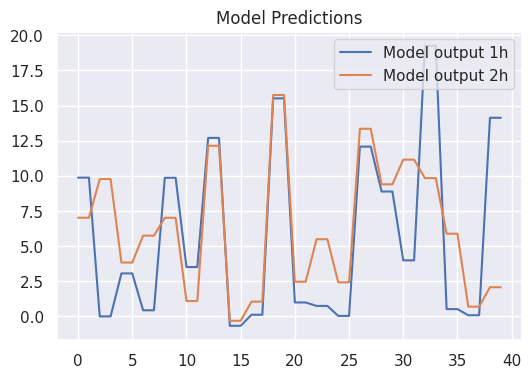

In [281]:
#make predictions on timestamps
timestamps = [
    "2022-08-04 23:24:00",
    "2022-08-05 00:24:00",
    "2022-08-08 04:58:00",
    "2022-08-08 05:58:00",
    "2022-08-11 21:13:00",
    "2022-08-11 22:13:00",
    "2022-08-16 07:10:00",
    "2022-08-16 08:10:00",
    "2022-08-18 17:30:00",
    "2022-08-18 18:27:00",
    "2022-08-21 11:07:00",
    "2022-08-21 12:07:00",
    "2022-08-24 15:09:00",
    "2022-08-24 16:09:00",
    "2022-08-29 03:05:00",
    "2022-08-29 04:01:00",
    "2022-08-31 06:37:00",
    "2022-08-31 07:34:00",
    "2022-09-03 15:48:00",
    "2022-09-03 16:42:00",
    "2022-09-05 18:34:00",
    "2022-09-05 19:35:00",
    "2022-09-08 07:44:00",
    "2022-09-08 08:44:00",
    "2022-09-10 05:50:00",
    "2022-09-10 06:50:00",
    "2022-09-12 09:32:00",
    "2022-09-12 10:32:00",
    "2022-09-17 18:25:00",
    "2022-09-17 19:25:00",
    "2022-09-20 23:43:00",
    "2022-09-21 00:40:00",
    "2022-09-23 13:36:00",
    "2022-09-23 14:36:00",
    "2022-09-26 07:09:00",
    "2022-09-26 08:10:00",
    "2022-09-29 03:14:00",
    "2022-09-29 04:10:00",
    "2022-10-01 19:27:00",
    "2022-10-01 20:27:00",
]

#get the nearest timestamp in the dataset
date_time, feature, target1,target2 = load_bikes(predict_hour=1)
#find the nearest timestamp in date_time that is not the same as the timestamp in the list
#find the index of the timestamp in the list
seq_len = 24
nearest_timestamps = []
for timestamp in timestamps:
    nearest_timestamp = min(date_time, key=lambda x: abs(x - pd.to_datetime(timestamp)))
    nearest_timestamps.append(nearest_timestamp)
    #print(f"nearest timestamp to {timestamp} is {nearest_timestamp}")

feats=[]

#get indexes of the nearest timestamps
indexes_of_nearest_timestamps = []
for timestamp in nearest_timestamps:
    indexes_of_nearest_timestamps.append(date_time.index(timestamp))

#print(indexes_of_nearest_timestamps)

x_sequences = []
for index in indexes_of_nearest_timestamps:
    x_sequences.append(feature[max(index-seq_len+1, 0):index+1])

print(x_sequences[0].shape)

x_sequences = np.array(x_sequences)

# Ensure your model is in evaluation mode
ltc_model.eval()

# Convert x_sequences to torch tensor
x_sequences_tensor = torch.from_numpy(x_sequences).float()

# If your model is on GPU, move the tensor to the GPU
# x_sequences_tensor = x_sequences_tensor.to(device)

# Perform prediction
with torch.no_grad():
    predictions_tuple = ltc_model(x_sequences_tensor)

predictions = predictions_tuple[0]
# Convert predictions back to numpy
predictions = predictions.cpu().numpy()

print(predictions.shape)

# Plot the first sequence predictions against actual values
plt.figure(figsize=(6, 4))
plt.plot(predictions[:, seq_len-1, 0], label="Model output 1h")
plt.plot(predictions[:, seq_len-1, 1], label="Model output 2h")

plt.title("Model Predictions")
plt.legend(loc="upper right")
plt.show()






In [282]:
#plotyl plot of predictions

# Plot the predictions using plotly
import plotly.graph_objects as go

from sklearn.metrics import mean_absolute_error


for i in range(0, len(predictions)):
    fig = go.Figure()
    if i % 2 == 0:
        
        print(f"prediction for {timestamps[i]} is {predictions[i, seq_len-1, 0]}")
       
        fig.add_trace(go.Scatter(y=predictions[i, :, 0],
                            mode='lines',
                            name='predictions'))
    else:
        print(f"prediction for {timestamps[i]} is {predictions[i, seq_len-1, 1]}")
        fig.add_trace(go.Scatter(y=predictions[i, :, 1],
                            mode='lines',
                            name='predictions'))

    #add features x_sequences_tensor 0
    fig.add_trace(go.Scatter(y=x_sequences_tensor[i, :, -1],
                        mode='lines',
                        name='features'))
    





    fig.show()

prediction for 2022-08-04 23:24:00 is 9.87842845916748


prediction for 2022-08-05 00:24:00 is 7.023556709289551


prediction for 2022-08-08 04:58:00 is 0.007151484489440918


prediction for 2022-08-08 05:58:00 is 9.774502754211426


prediction for 2022-08-11 21:13:00 is 3.06514573097229


prediction for 2022-08-11 22:13:00 is 3.838460922241211


prediction for 2022-08-16 07:10:00 is 0.44185006618499756


prediction for 2022-08-16 08:10:00 is 5.752060890197754


prediction for 2022-08-18 17:30:00 is 9.866194725036621


prediction for 2022-08-18 18:27:00 is 7.020252704620361


prediction for 2022-08-21 11:07:00 is 3.5167367458343506


prediction for 2022-08-21 12:07:00 is 1.1038264036178589


prediction for 2022-08-24 15:09:00 is 12.704172134399414


prediction for 2022-08-24 16:09:00 is 12.143759727478027


prediction for 2022-08-29 03:05:00 is -0.6619426012039185


prediction for 2022-08-29 04:01:00 is -0.304384708404541


prediction for 2022-08-31 06:37:00 is 0.12439596652984619


prediction for 2022-08-31 07:34:00 is 1.057563066482544


prediction for 2022-09-03 15:48:00 is 15.516124725341797


prediction for 2022-09-03 16:42:00 is 15.752884864807129


prediction for 2022-09-05 18:34:00 is 0.9977229237556458


prediction for 2022-09-05 19:35:00 is 2.4731264114379883


prediction for 2022-09-08 07:44:00 is 0.7527590394020081


prediction for 2022-09-08 08:44:00 is 5.4968647956848145


prediction for 2022-09-10 05:50:00 is 0.043491244316101074


prediction for 2022-09-10 06:50:00 is 2.4310646057128906


prediction for 2022-09-12 09:32:00 is 12.083917617797852


prediction for 2022-09-12 10:32:00 is 13.353039741516113


prediction for 2022-09-17 18:25:00 is 8.8897066116333


prediction for 2022-09-17 19:25:00 is 9.398968696594238


prediction for 2022-09-20 23:43:00 is 3.993377685546875


prediction for 2022-09-21 00:40:00 is 11.156445503234863


prediction for 2022-09-23 13:36:00 is 19.253564834594727


prediction for 2022-09-23 14:36:00 is 9.843667984008789


prediction for 2022-09-26 07:09:00 is 0.5258862972259521


prediction for 2022-09-26 08:10:00 is 5.88876485824585


prediction for 2022-09-29 03:14:00 is 0.08838140964508057


prediction for 2022-09-29 04:10:00 is 0.7008014917373657


prediction for 2022-10-01 19:27:00 is 14.133575439453125


prediction for 2022-10-01 20:27:00 is 2.0816891193389893


In [107]:
predictions[:, seq_len-1, 0]

array([ 1.2257320e+01,  1.2257320e+01,  9.6832275e-02,  9.6832275e-02,
        1.8091465e+00,  1.8091465e+00,  1.0273936e+00,  1.0273936e+00,
        8.3470955e+00,  8.3470955e+00,  2.5192127e+00,  2.5192127e+00,
        1.6481625e+01,  1.6481625e+01, -1.0048962e-01, -1.0048962e-01,
       -1.6774416e-02, -1.6774416e-02,  1.8410103e+01,  1.8410103e+01,
        3.8053465e-01,  3.8053465e-01,  6.8727994e-01,  6.8727994e-01,
        1.1774933e-01,  1.1774933e-01,  1.3468177e+01,  1.3468177e+01,
        1.0683984e+01,  1.0683984e+01,  5.1435041e-01,  5.1435041e-01,
        1.9773333e+01,  1.9773333e+01,  8.7620729e-01,  8.7620729e-01,
       -1.0120416e-01, -1.0120416e-01,  1.7917236e+01,  1.7917236e+01],
      dtype=float32)

In [283]:
#save tocsv as timestamp, prediction
#convert to dataframe

final=[]
for i in range(0, len(predictions)):
    if i % 2 == 0:
        final.append(abs(int(predictions[i, seq_len-1, 0])))
    else:
        p2=abs(int(predictions[i, seq_len-1, 1]))
        p1=abs(int(predictions[i, seq_len-1, 0]))
        final.append(int(p2+p1/2))



df = pd.DataFrame(final, columns=["prediction"])
df["timestamp"] = timestamps
df.to_csv("/d/hpc/home/ld8435/liquid_time_constant_networks/predictions.csv", index=False)
#open bicikelj_terfrfst_xgb_1h_fullds_new_pred_method_new_feats3
to_Send=pd.read_csv("/d/hpc/home/ld8435/liquid_time_constant_networks/pppp.csv")
to_Send["timestamp"]=pd.to_datetime(to_Send["timestamp"])

#set colum PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE valuses to predictions rounded to int and  negative beeeing 0

to_Send["PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE"]=final
to_Send["PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE"]=to_Send["PREŠERNOV TRG-PETKOVŠKOVO NABREŽJE"].clip(lower=0)

#save to csv
to_Send.to_csv("/d/hpc/home/ld8435/liquid_time_constant_networks/ok.csv", index=False)

In [125]:
def rolling_forecast(model, initial_sequence, num_predictions):
    # Ensure the model is in evaluation mode
    model.eval()
    
    # The list to hold the results
    predictions = []
    
    # The current sequence is the initial sequence
    current_sequence = initial_sequence
    
    # Make the specified number of predictions
    for _ in range(num_predictions):
        # Get the last seq_len values
        input_sequence = current_sequence[-seq_len:]

        
        # Add a batch dimension and convert to a tensor
        input_tensor = torch.FloatTensor(input_sequence).unsqueeze(0)
        print("input_sequence", input_sequence.shape)

        
        # If your model is on GPU, move the tensor to the GPU
        # input_tensor = input_tensor.to(device)
        
        # Perform prediction
        with torch.no_grad():
            prediction,state = model(input_tensor)

        print("prediction", prediction.shape)
        print("state", state.shape)
        print("state", state)
        
        # Get the last prediction
        last_prediction = prediction[0, -1, 0].cpu().numpy()
        
        # Append the last prediction to the predictions list
        predictions.append(last_prediction)
        
        # Append the last prediction to the current sequence
        current_sequence = np.append(current_sequence, last_prediction)
    
    # Return the predictions
    return predictions

initial_sequence = feature[0:seq_len]  # Initial sequence is the first seq_len values
num_predictions = 100  # Number of predictions to make

predictions = rolling_forecast(ltc_model, initial_sequence, num_predictions)

# Now you can plot the predictions
plt.figure(figsize=(6, 4))
plt.plot(predictions, label="Model output")
plt.title("Model Predictions")
plt.legend(loc="upper right")
plt.show()

input_sequence (24, 6)
prediction torch.Size([1, 24, 1])
state torch.Size([1, 64])
state tensor([[ 3.7029, -2.3198, -0.4547, -0.5521, -1.5549, -3.2728, -0.7861, -1.0494,
         -1.9537,  2.4430, -0.3484, -2.6538, -1.0174, -0.0801, -1.4780,  1.2272,
         -2.7231, -2.2527, -1.2429, -0.3657, -0.1584, -4.5855, -4.2341, -0.8473,
         -0.6286, -1.5616, -2.3719,  1.2142, -0.0997, -3.2930, -0.1502, -2.8985,
         -1.1761, -1.8768,  0.3535, -3.5558,  0.2788,  0.1031, -0.6197, -2.0769,
         -0.4122, -1.7298, -1.5899, -0.8481, -1.3297, -2.0463, -3.3150, -3.8412,
         -3.1932,  0.0819, -1.0554, -1.4618, -0.5505,  0.0987, -1.2653,  1.0571,
         -0.9972,  1.3565, -2.1684, -3.2735, -1.3542,  1.2956, -1.6026,  2.0193]])
input_sequence (24,)


RuntimeError: The size of tensor a (24) must match the size of tensor b (6) at non-singleton dimension 1